<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/ESAA_%EC%88%98%EC%83%81%EC%9E%91%EB%A6%AC%EB%B7%B0_%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89_%EC%84%BC%EC%84%9C%EC%9D%98_%EC%95%88%ED%85%8C%EB%82%98_%EC%84%B1%EB%8A%A5_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[자율주행 센서의 안테나 성능 예측 AI 경진대회]**

In [1]:
import platform
platform.platform()

'Linux-5.10.147+-x86_64-with-glibc2.29'

In [2]:
!cat /etc/issue.net

Ubuntu 20.04.5 LTS


In [3]:
!python --version

Python 3.8.10


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## 1.1 데이터 입/출력 경로 지정

In [6]:
#코랩 환경 경로 설정 
DATA_PATH = '/content/drive/MyDrive/open/'

In [7]:
# 로컬 환경 경로 설정
DATA_PATH = '/data/'

## 1.2 필요 라이브러리 설치

In [8]:
# Optuna 설치
!pip install --quiet --no-cache-dir git+https://github.com/optuna/optuna

# Catboost 설치
!pip install --quiet catboost

# XGB GPU 버전 설치
!pip uninstall --quiet -y xgboost
!pip install --quiet xgboost

# LGBM GPU 버전 설치
! git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.6 MB/s eta 0:00:00
Cloning into 'LightGBM'...
remote: Enumerating objects: 28834, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 28834 (delta 36), reused 62 (delta 30), pack-reused 28739
Receiving objects: 100% (28834/28834), 20.22 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (21364/21364), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_do

## 1.3 라이브러리 로드

In [15]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import joblib

import warnings

warnings.filterwarnings("ignore")

In [29]:
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.5 MB/s eta 0:00:00
  Created wheel for alembic: filename=alembic-1.9.3-py3-none-any.whl size=210578 sha256=6babd48908d54101b2012c4fb190927dd993594c1c2d8e69f9a0aac06e371dc8
  Stored in directory: /root/.cache/pip/wheels/4f/5b/74/1ce76c741045a20a9394fa0c8f8fcc45b6f2112ab8ec1a78ff
Successfully built alembic


In [30]:
import optuna 
from optuna import Trial, visualization

## 1.4 시드 고정

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) 
SEED = 42

# **2. 데이터 전처리**

In [53]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/open/train.csv')

# X Y 데이터 분리
X_train = train.filter(regex='X')
Y_train = train.filter(regex='Y')

In [54]:
# 결과에 영향 낮은 인자 제거(SHAP(XAI)을 통한 Feature Selection 진행함)
X_train = X_train.drop(['X_04', 'X_23', 'X_47', 'X_48', 'X_10', 'X_11', 'X_02'], axis=1)

In [55]:
# X_33(스크류 삽입 깊이) 이상치 제거

drop_idx = X_train.loc[X_train['X_33'] > 6 ].index

X_train = X_train.drop(drop_idx, axis = 0)
Y_train = Y_train.drop(drop_idx, axis = 0)

X_train = X_train.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)

* 일부 인자들 사이에 강한 상관관계 존재(상관계수행렬 확인)
* 다중공선성 제거 위해 PCA 통한 차원 축소 시도

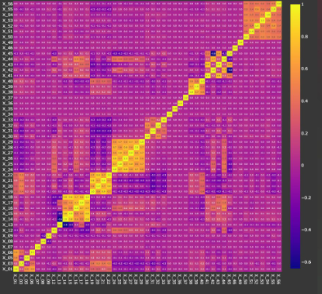

In [56]:
# PCA 클래스 설정
class PCA_transform:

  def __init__(self):
    self.cols_list = []
    self.pca_list = []
    self.n_pca_list = []
    self.size = 0
  
  # PCA 클래스의 학습 및 input 값 변환
  def fit_transform(self, X_input, col, n_pca):

    X_pca = X_input[col]

    # n차원으로 차원 축소, target 정보는 제외
    pca = PCA(n_components = n_pca)

    # PCA 학습
    pca.fit(X_pca)

    # PCA transform 후 데이터프레임으로 자료형 변경
    X_pca = pca.transform(X_pca)
    X_pca = pd.DataFrame(X_pca, columns = self.naming(n_pca))

    X_input = pd.concat([X_input, X_pca], axis = 1)
    X_input = X_input.drop(col, axis = 1)

    self.cols_list.append(col)
    self.pca_list.append(pca)
    self.n_pca_list.append(n_pca)
    self.size += 1

    return X_input

  # 학습된 PCA 값으로 transform
  def transform(self, X_input):
    for idx in range(self.size):
      X_input = self._idx_transform(X_input, idx)
    
    return X_input

  # n번째 PCA 변환
  def _idx_transform(self, X_input, idx):
    X_pca = X_input[self.cols_list[idx]]

    # pca transform 후 데이터프레임으로 자료형 변경
    X_pca = self.pca_list[idx].transform(X_pca)
    X_pca = pd.DataFrame(X_pca, columns = self.naming(self.n_pca_list[idx], idx))

    X_input = pd.concat([X_input, X_pca], axis = 1)
    X_input = X_input.drop(self.cols_list[idx], axis = 1)

    return X_input

  # PCA 된 컬럼 이름 규칙
  def naming(self, number, name = None):
    if (name is None):
      name = self.size
    names = []
    for idx in range(number):
      names.append(f'PCA_{str(name)}_{idx}')
    return names

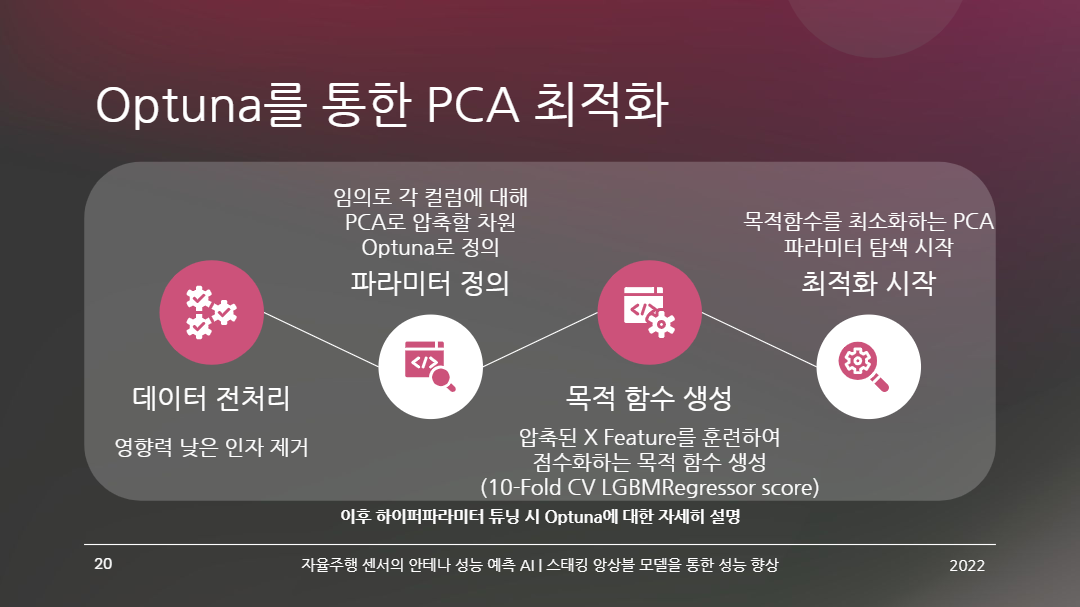

In [57]:
# Optuna로 최적화된 PCA 파라미터 적용
pca_5 = PCA_transform()
X_train = pca_5.fit_transform(X_train, ['X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18'], 5)
X_train = pca_5.fit_transform(X_train, ['X_19', 'X_20', 'X_21', 'X_22'], 2)
X_train = pca_5.fit_transform(X_train, ['X_34', 'X_35', 'X_36', 'X_37'], 1)
X_train = pca_5.fit_transform(X_train, ['X_41', 'X_42', 'X_43', 'X_44', 'X_45'], 1)
X_train = pca_5.fit_transform(X_train, ['X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'], 2)

# **3. 평가산식 정의**

In [58]:
def nrmse(y_val, y_pred):
  rmse = mean_squared_error(y_val, y_pred, squared=False)
  nrmse = rmse/np.mean(np.abs(y_val))
  return nrmse

def lg_nrmse(y_val, y_pred):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여

    y_val = pd.DataFrame(y_val)
    y_pred = pd.DataFrame(y_pred)

    all_nrmse = []
    for idx in range(0,14):
        all_nrmse.append(nrmse(y_val.iloc[:,idx], y_pred.iloc[:,idx]))
        
    score = 1.2 * np.sum(all_nrmse[:7]) + 1.0 * np.sum(all_nrmse[7:14])
    return score

# **4. 모델링**

## 4.1 Cross-validation을 통해 학습하는 ML class

In [59]:
class CV_ml_model:
  # 머신러닝 모델, X_train, Y_train을 인자로 받음
  def __init__(self, model, X_train, Y_train):
    self.model = model
    self.name = model().__class__.__name__
    self.train_preds = [None] * 14
    self.trained_models = [None] * 14
    self.test_preds = [None] * 14
    self.X_train = self.to_np(X_train)
    self.Y_train = self.to_np(Y_train)


  # 넘파이 변환
  def to_np(self, input):
    if (type(input) == pd.core.frame.DataFrame):
      return input.to_numpy()
    return input


  # 이름 재설정
  def set_name(self, name):
    self.name = name

  
  # Y 하나에 대해 머신러닝 수행
  def y_fit(self, n_folds, y_idx, X_train = None, param = {}, save = False):
    # X_train 따로 설정하지 않을 시 최초 입력 데이터 적용
    if (X_train is None):
      X_train = self.X_train

    # 이미 학습된 y_idx일시 학습 중지
    if (self.train_preds[y_idx] is not None):
      return

    # n_folds 숫자 만큼 학습된 모델이 들어갈 리스트 생성
    trained_y_models = [None] * n_folds

    # 예측 결과를 넣을 ndarray 생성
    train_fold_pred = np.zeros((X_train.shape[0], 1))

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train)):
      #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
      X_tr = X_train[train_index]
      y_tr = self.Y_train[:,y_idx][train_index]
      X_val = X_train[valid_index]

      # 폴드 세트 내부에서 만들어진 학습 데이터로 기반 모델의 학습 수행.
      trained_model = self.model(**param).fit(X_tr , y_tr)  
      # 폴드 세트 내부에서 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
      train_fold_pred[valid_index, :] = trained_model.predict(X_val).reshape(-1,1)
      # 학습 완료된 모델 리스트 내에 저장
      trained_y_models[folder_counter] = trained_model
    
    # 예측 결과 class 내 저장
    self.train_preds[y_idx] = train_fold_pred
    # 학습 완료된 모델 class 내 저장
    self.trained_models[y_idx] = trained_y_models

    # 학습 완료시 모델을 파일로 저장
    if (save):
      self.save()

  
  # 모델 경량화
  def slim_y_fit(self, n_folds, y_idx, X_train = None, param = {}, save = False):
    # X_train 따로 설정하지 않을 시 최초 입력 데이터 적용
    if (X_train is None):
      X_train = self.X_train

    # 이미 학습된 y_idx일시 학습 중지
    if (self.train_preds[y_idx] is not None):
      return

    # 예측 결과를 넣을 ndarray 생성
    train_fold_pred = np.zeros((X_train.shape[0], 1))

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train)):
      #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
      X_tr = X_train[train_index] 
      y_tr = self.Y_train[:,y_idx][train_index] 
      X_val = X_train[valid_index]  

      #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
      trained_model = self.model(**param).fit(X_tr , y_tr)  
      #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
      train_fold_pred[valid_index, :] = trained_model.predict(X_val).reshape(-1,1)
    
    # 예측 결과 class 내 저장
    self.train_preds[y_idx] = train_fold_pred
    # 학습 데이터 전체로 모델 학습 후 학습 완료된 모델 class 내 저장
    self.trained_models[y_idx] = [self.model(**param).fit(X_train , self.Y_train[:,y_idx])]

    # 학습 완료시 모델을 파일로 저장
    if (save):
      self.save()
  

  # Y 하나에 대해 예측 수행
  def y_predict(self, X_test, y_idx):
    # 학습 완료된 모델 갯수 확인
    size = len(self.trained_models[y_idx])
    # 예측 결과를 넣을 ndarray 생성
    test_pred = np.zeros((X_test.shape[0], size))

    # 학습 완료된 모델 갯수만큼 예측 수행 
    for counter in range(size):
      test_pred[:, counter] = self.trained_models[y_idx][counter].predict(X_test)

    # 예측된 결과값에 대해 평균을 구함
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    # 예측된 결과값을 class 내 저장
    self.test_preds[y_idx] = test_pred_mean

    return test_pred_mean
  

  # 머신러닝 훈련 실행
  # 파라미터 직접 적용시 동일 파라미터가 전체 적용
  # 불러오기 적용시 개별 적용
  def fit(self, n_folds, use_params = False, params = None, save = False):
    print(self.name, 'Started')

    # use_params이 참이고, params가 없을 시 class 이름으로 하이퍼파라미터 튜닝된 파라미터 불러오기
    if (use_params):
      if (params is None):
        params = self.load_params(self.name)
        print('Params Loaded!')
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.y_fit(n_folds, y_idx, None, params[y_idx], save)

      # use_params이 참이고, params이 존재할 시 모델 전체에 동일 params 적용
      else:
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.y_fit(n_folds, y_idx, None, params, save)
    
    # 파라미터 미적용
    else:
      for y_idx in range(14):
        print(y_idx, end= ' ')
        self.y_fit(n_folds, y_idx, save = save)
    
    print(self.name, 'Trained!')


  # 머신러닝 훈련 실행
  # 모델 저장시 하나의 모델로 저장하여 모델 경량화
  def slim_fit(self, n_folds, use_params = False, params = None, save = False):
    print(self.name, 'Started')

    # use_params이 참이고, params가 없을 시 class 이름으로 하이퍼파라미터 튜닝된 파라미터 불러오기
    if (use_params):
      if (params is None):
        params = self.load_params(self.name)
        print('Params Loaded!')
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.slim_y_fit(n_folds, y_idx, None, params[y_idx], save)

      # use_params이 참이고, params이 존재할 시 모델 전체에 동일 params 적용
      else:
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.slim_y_fit(n_folds, y_idx, None, params, save)
    
    # 파라미터 미적용
    else:
      for y_idx in range(14):
        print(y_idx, end= ' ')
        self.slim_y_fit(n_folds, y_idx, save = save)
    
    print(self.name, 'Slim!')


  # 학습된 모델을 통해 예측
  def predict(self, X_test):
    for y_idx in range(14):
      self.y_predict(X_test, y_idx)

    return np.hstack(self.test_preds)


  # 예측된 Y_train 결과 반환
  def get_train_preds(self):
    return np.hstack(self.train_preds)


  # 예측된 Y_test 결과 반환
  def get_test_preds(self):
    return np.hstack(self.test_preds)


  # nrmse 값 반환
  def nrmse(self, y_idx):
    rmse = mean_squared_error(self.Y_train[:,y_idx], self.train_preds[y_idx], squared=False)
    nrmse = rmse/np.mean(np.abs(self.Y_train[:,y_idx]))
    return nrmse


  # 모델의 Cross-validation 점수 반환
  def score(self):
    all_nrmse = [None] * 14
    for y_idx in range(14):
      all_nrmse[y_idx] = self.nrmse(y_idx)

    score = 1.2 * np.sum(all_nrmse[:7]) + 1.0 * np.sum(all_nrmse[7:14])
    return score
  

  # 모델을 현재 이름으로 저장
  def save(self):
    saved_data = self.model, self.name, self.train_preds, self.trained_models, self.test_preds
    try:
      os.mkdir(DATA_PATH + "ML_model")
    except:
      pass
    joblib.dump(saved_data, DATA_PATH + "ML_model/saved_" + self.name + ".pkl")
    # print(self.name, 'Saved!')


  # 모델을 현재 이름 혹은 입력한 이름으로 불러오기
  def load(self, name = None):
    if (not name):
      name = self.name
    try:
      loaded_data = joblib.load(DATA_PATH + "ML_model/saved_" + name + ".pkl")
      self.model, self.name, self.train_preds, self.trained_models, self.test_preds = loaded_data
      print(self.name, 'Loaded!')

      # 학습 전체가 완료된 모델일시 참 반환, 학습이 남은 모델일시 거짓 반환
      if (self.trained_models[13] is None):
        return False
      else:
        return True
    except:
      print(self.name, 'didnt loaded')
      return False


  # 파라미터 불러오기
  def load_params(self, name):
    params = [None] * 14
    for y_idx in range(14):
      try:
        load_study = joblib.load(DATA_PATH + "tune_param/" + name + "/tune_" + str(y_idx) + ".pkl")
        params[y_idx] = load_study.best_trial.params
      except:
        print(name, y_idx,'params didnt loaded')

    return params

## 4.2 CV_ml_model을 확장한 Stacking ensemble을 위한 Meta Learning class

In [60]:
class meta_ml_model(CV_ml_model):
  def __init__(self, model, X_train, Y_train):
    super().__init__(model, X_train, Y_train)
    self.ml_models = []
    self.trained = []

  
  # 머신러닝 모델 추가
  # 훈련된 CV_ml_model을 받음
  def add_trained_ml_models(self, *models:CV_ml_model):
    for model in models:
      self.ml_models.append(model)
      self.trained.append(True)


  # 머신러닝 모델 추가
  # 훈련안된 머신러닝 모델 함수를 받음
  def add_new_ml_models(self, *models):
    for model in models:
      new_model = CV_ml_model(model, self.X_train, self.Y_train)
      self.ml_models.append(new_model)
      self.trained.append(False)


  # 머신러닝 모델 전체 훈련
  # 훈련되어있지 않은 모델만 훈련함
  def fit_ml_model(self, n_folds, save = False):
    for idx, model in enumerate(self.ml_models):
      if (not self.trained[idx]):
        model.fit(n_folds, save=save)
        self.trained[idx] = True


  # class 내에 추가된 머신러닝 모델 전체 불러오기
  def load_all_models(self):
    for idx, model in enumerate(self.ml_models):
      self.trained[idx] = model.load()


  # class 내에 추가된 머신러닝 모델 전체 저장
  def save_all_models(self):
    for model in self.ml_models:
      model.save()


  # 훈련 여부 수동 체크
  def trained_check(self, idx):
    self.trained[idx] = True


  # 머신러닝 모델 하나 훈련 (파라미터 입력 가능)
  def fit_one_ml_model(self, n_folds, model_idx, use_params = False, params = None, save=False):
    self.ml_models[model_idx].fit(n_folds, use_params, params, save)
    self.trained[model_idx] = True


  # 머신러닝 모델 하나 경량 훈련 (파라미터 입력 가능)
  def slim_fit_one_ml_model(self, n_folds, model_idx, use_params = False, params = None, save=False):
    self.ml_models[model_idx].slim_fit(n_folds, use_params, params, save)
    self.trained[model_idx] = True

  
  # 모델 전체 입력값 예측
  def predict_ml_model(self, X_test):
    for model in self.ml_models:
      model.predict(X_test)

  
  # 모델 이름 변경
  def set_ml_name(self, model_idx, name):
    self.ml_models[model_idx].set_name(name)


  # 메타 훈련을 위해 해당 Y인덱스만 남기고 훈련
  # 훈련되지 않은 모델은 훈련 진행
  def meta_fit(self, n_folds):
    Y_preds = []

    # X_train, Y_train을 통해 학습된 Y_pred를 Y_preds에 추가
    for idx, model in enumerate(self.ml_models):
      if (not self.trained[idx]):
        model.fit(n_folds)
        self.trained[idx] = True
      Y_preds.append(model.get_train_preds())

    Y_preds = np.hstack(Y_preds)

    for y_idx in range(14):
      print(y_idx, end= ' ')
      # y_idx와 동일한 y_pred만을 메타 러닝
      X_meta_train = Y_preds[:, [i for i in range(Y_preds.shape[1]) if i % 14 == y_idx]]
      super().y_fit(n_folds, y_idx, X_meta_train)

    print('Meta', self.name, 'Trained!')


  # 학습된 모델을 통해 메타 예측
  # meta_fit 선행 필수
  def meta_predict(self, X_test):
    Y_preds = []
    X_test = super().to_np(X_test)

    # X_test를 통해 예측된 Y_pred를 Y_preds에 추가
    for idx, model in enumerate(self.ml_models):
      print(model.name, 'Predict Started!')
      model.predict(X_test)
      Y_preds.append(model.get_test_preds())

    Y_preds = np.hstack(Y_preds)

    print('Meta Train Started!')

    for y_idx in range(14):
      # y_idx와 동일한 y_pred만을 통해 예측
      X_meta_test = Y_preds[:, [i for i in range(Y_preds.shape[1]) if i % 14 == y_idx]]
      super().y_predict(X_meta_test, y_idx)

    return np.hstack(self.test_preds)
  
  
  # 전체 모델에 대한 점수 확인
  def scores(self):
    scores = {}
    for model in self.ml_models:
      scores[model.name] = model.score()
    return scores

## 4.3 Stacking ensemble 수행

### 4.3.1 메타 모델 생성

In [61]:
# 메타 모델 생성
meta_model = meta_ml_model(Ridge, X_train, Y_train)
meta_model.set_name('Meta_Ridge')

### 4.3.2 메타 모델 내에 기반 모델 추가

In [62]:
# 메타모델 내에 튜닝되지 않은 기반 모델 추가
meta_model.add_new_ml_models(
  LinearRegression, Ridge, Lasso, ElasticNet, LassoLars,
  OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, GradientBoostingRegressor, 
  HistGradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor
    )

In [63]:
# 메타모델 내에 하이퍼파라미터 튜닝된 기반 모델 추가
meta_model.add_new_ml_models(
  HistGradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor
    )

meta_model.set_ml_name(13, 'HistGradientBoostingRegressor_tune')
meta_model.set_ml_name(14, 'XGBRegressor_tune')
meta_model.set_ml_name(15, 'LGBMRegressor_tune')
meta_model.set_ml_name(16, 'CatBoostRegressor_tune')

### 4.3.3 학습된 모델을 불러오거나 직접 학습

In [64]:
# 학습된 모델 불러오기
meta_model.load_all_models()
meta_model.load()

LinearRegression didnt loaded
Ridge didnt loaded
Lasso didnt loaded
ElasticNet didnt loaded
LassoLars didnt loaded
OrthogonalMatchingPursuit didnt loaded
BayesianRidge didnt loaded
ARDRegression didnt loaded
GradientBoostingRegressor didnt loaded
HistGradientBoostingRegressor didnt loaded
XGBRegressor didnt loaded
LGBMRegressor didnt loaded
CatBoostRegressor didnt loaded
HistGradientBoostingRegressor_tune didnt loaded
XGBRegressor_tune didnt loaded
LGBMRegressor_tune didnt loaded
CatBoostRegressor_tune didnt loaded
Meta_Ridge didnt loaded


False

In [ ]:
# 학습된 모델을 불러오지 않고 직접 학습하기

# GradientBoostingRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 8)

# HistGradientBoostingRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 9)

# XGBRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 10, True, {'objective': 'reg:squarederror', 'random_state': SEED})

# LGBMRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 11, True, {'random_state': SEED, 'verbose': -1, 'device': 'gpu'})

# CatBoostRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 12, True, {'loss_function': 'RMSE', 'logging_level': 'Silent', 'random_state': SEED})

# HistGradientBoostingRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 13, True)

# XGBRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 14, True)

# LGBMRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(5, 15, True)

# CatBoostRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 16, True)

# 학습 안된 기반 모델 학습
meta_model.fit_ml_model(10)

# 기반 모델의 예측 결과를 최종 데이터 세트로 하여 메타 모델 학습
meta_model.meta_fit(10)

# **5. 성능평가**

In [ ]:
meta_model.scores()

In [ ]:
meta_model.score()

# **6. 테스트 데이터 예측**

In [ ]:
test = pd.read_csv(DATA_PATH + 'test.csv').drop(columns=['ID'])

# 영향 없는 인자 제거
X_test = test.drop(['X_02', 'X_04', 'X_10', 'X_11', 'X_23', 'X_47', 'X_48'], axis=1)

# PCA 변환
X_test = pca_5.transform(X_test)

%%time

Y_pred = meta_model.meta_predict(X_test)